In [1]:
!pip install -q langchain_anthropic langgraph dotenv langsmith

# @traceable(name="My Function Name") to trace

In [2]:
# LLM
from dotenv import load_dotenv
from langsmith import traceable
load_dotenv()

import os
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest", anthropic_api_key=os.getenv("ANTHROPIC_API_KEY"))


In [3]:
import logging
import json

logging.basicConfig(
    filename="llm_trace.log",
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
)

def log_json(data, tag="log"):
    with open("trace.jsonl", "a") as f:
        f.write(json.dumps({"tag": tag, **data}) + "\n")



In [4]:
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [5]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send



# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    logging.info("Planning report with topic: %s", state["topic"])
    logging.info("Generated sections: %s", report_sections.sections)
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    logging.info("Writing section: %s", state["section"].name)
    logging.info("Section output: %s", section.content)
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    
    logging.info("Synthesizing report from sections")
    logging.info("Final report content: %s", completed_report_sections)
    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

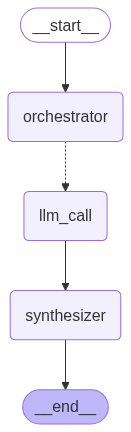

In [7]:
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage


state = orchestrator_worker.invoke({"topic": "My manager has been pressing me on efficiency, i believe i am less efficient than i should be, however somehow i cannot perform to my max currently. How should i handle this situation?"})



from IPython.display import Markdown

Markdown(state["final_report"])

Here's a draft report section:

Current Situation Analysis

This analysis examines the key factors affecting work efficiency and productivity in the current operational environment. Understanding these elements is crucial for identifying areas for improvement and developing targeted solutions.

Workload Assessment
The current workload distribution shows significant variations across teams and individuals. Key findings include:
- Peak periods creating bottlenecks in workflow
- Uneven task allocation leading to overburden in some areas
- Project deadlines often overlapping, causing resource constraints
- Increasing complexity of assignments requiring additional time investment

Work Environment Evaluation 
The physical and digital work environment impacts daily operations in several ways:
- Office layout and ergonomics affecting comfort and focus
- Noise levels and distractions in shared spaces
- Technology infrastructure and tool accessibility
- Remote work considerations and virtual collaboration challenges

Personal Energy Management
Individual energy levels and capacity show patterns that influence productivity:
- Natural energy fluctuations throughout the workday
- Impact of breaks and recovery periods on sustained performance
- Stress levels and their effect on focus and efficiency
- Work-life balance considerations

Barriers to Optimal Performance
Several obstacles have been identified that potentially limit peak efficiency:
- Communication gaps between teams and departments
- Process bottlenecks and administrative hurdles
- Skill gaps requiring additional training or support
- Time management challenges and interruption patterns

Understanding these interconnected factors provides a foundation for developing targeted improvements in work efficiency. The analysis suggests that a multi-faceted approach addressing both organizational and individual factors will be necessary for meaningful enhancement of performance outcomes.

This assessment serves as a baseline for identifying priority areas and developing specific recommendations for optimization.

---

Here's a draft report section on Understanding Efficiency Blockers:

Understanding Efficiency Blockers

Efficiency blockers are significant obstacles that prevent individuals and teams from performing at their optimal level. Understanding these barriers is crucial for implementing effective solutions and maintaining high productivity. This section explores the most common efficiency blockers and their impact on workplace performance.

Burnout
Professional burnout is a state of physical, emotional, and mental exhaustion resulting from prolonged stress and overwork. Key indicators include:
- Decreased motivation and engagement
- Physical fatigue and mental fog
- Reduced quality of work
- Increased cynicism and detachment
- Higher error rates and missed deadlines

Lack of Motivation
When employees lose their drive and sense of purpose, efficiency naturally declines. Common causes include:
- Absence of clear career progression
- Insufficient recognition or rewards
- Misalignment between personal and organizational values
- Repetitive or unstimulating work
- Poor workplace culture

Unclear Priorities
Without well-defined priorities, employees often struggle to:
- Allocate time effectively
- Make decisions confidently
- Focus on high-impact tasks
- Meet organizational objectives
- Balance competing demands

Distractions
Modern workplaces present numerous distractions that can significantly impact productivity:
- Digital interruptions (emails, messages, notifications)
- Open office environments
- Unnecessary meetings
- Social media
- Personal devices

Skill Gaps
When employees lack necessary skills or knowledge, efficiency suffers through:
- Increased time to complete tasks
- Lower quality outputs
- Reduced confidence
- Dependency on others
- Limited problem-solving ability

Impact on Organizational Performance
These efficiency blockers can lead to:
- Decreased productivity
- Lower employee retention
- Reduced innovation
- Higher operational costs
- Diminished competitive advantage

Addressing Efficiency Blockers
To overcome these challenges, organizations should:
1. Regularly assess and monitor employee wellbeing
2. Provide clear goals and expectations
3. Implement effective time management systems
4. Create distraction-free work environments
5. Invest in continuous learning and development
6. Foster open communication channels
7. Recognize and reward good performance

Understanding efficiency blockers is the first step toward creating a more productive workplace. By identifying and addressing these obstacles, organizations can better support their employees and maintain higher levels of performance and engagement.

---

Here's a draft report section on Self-Assessment Tools:

Self-Assessment Tools

Understanding one's personal productivity patterns, energy cycles, and work habits is essential for optimizing performance and identifying areas for improvement. This section explores various self-assessment tools and techniques that individuals can use to gain deeper insights into their work patterns and make data-driven decisions about their productivity strategies.

Productivity Tracking Methods

Time Logging
- Detailed activity tracking using digital or paper-based time logs
- Recording start/end times, task types, and completion status
- Identifying time expenditure patterns and potential inefficiencies

Energy Mapping
- Monitoring personal energy levels throughout the day
- Documenting peak performance periods and natural slumps
- Creating visual representations of daily/weekly energy cycles

Task Analysis Tools
- Work breakdown structures for complex projects
- Priority matrices for task categorization
- Effort vs. impact assessments

Digital Monitoring Solutions

Productivity Apps
- Automated time-tracking software
- Project management platforms with analytics
- Focus and distraction monitoring tools

Biometric Tracking
- Sleep quality monitoring
- Stress level indicators
- Physical activity measurements

Performance Metrics

Quantitative Measures
- Task completion rates
- Project turnaround times
- Focus session duration
- Meeting efficiency scores

Qualitative Assessments
- Work quality evaluations
- Satisfaction ratings
- Stress level indicators
- Work-life balance metrics

Self-Reflection Techniques

Structured Reviews
- Daily accomplishment journaling
- Weekly progress assessments
- Monthly performance evaluations
- Quarterly goal reviews

Feedback Integration
- Peer reviews
- Supervisor input
- Client feedback
- Self-critique sessions

Implementation Framework

Data Collection
1. Select appropriate tracking tools
2. Establish baseline measurements
3. Maintain consistent monitoring
4. Document environmental factors

Analysis Process
1. Review collected data regularly
2. Identify patterns and trends
3. Compare against benchmarks
4. Draw actionable insights

Improvement Cycle
1. Set specific improvement targets
2. Implement changes based on findings
3. Monitor impact of adjustments
4. Refine strategies as needed

Best Practices

Consistency
- Maintain regular assessment schedules
- Use standardized measurement methods
- Document contextual factors
- Track long-term trends

Objectivity
- Focus on measurable metrics
- Avoid emotional bias
- Seek external validation
- Use multiple data points

Integration
- Align with organizational goals
- Consider team dynamics
- Account for external factors
- Balance multiple priorities

Common Challenges and Solutions

Data Overload
- Focus on key metrics
- Establish clear priorities
- Use automated tools
- Implement regular review cycles

Maintaining Motivation
- Set realistic goals
- Celebrate progress
- Share results with accountability partners
- Adjust methods as needed

Time Management
- Schedule regular assessment periods
- Automate data collection where possible
- Use efficient review processes
- Focus on high-impact metrics

By implementing these self-assessment tools and techniques, individuals can develop a clear understanding of their productivity patterns and make informed decisions about optimizing their work habits. Regular evaluation and adjustment of these methods ensures continuous improvement and adaptation to changing circumstances.

The success of self-assessment initiatives depends on consistent application, honest evaluation, and willingness to make changes based on findings. Organizations can support these efforts by providing necessary tools, training, and time for regular assessment activities.

---

Here's a draft report section on Communication with Management:

Communication with Management

Effective communication with management is crucial when addressing performance concerns and working towards improvement. This section outlines key strategies for engaging in productive discussions with your manager and establishing a clear path forward.

Preparing for the Discussion

Before meeting with your manager:
- Document specific examples of performance concerns
- Reflect on potential causes and solutions
- Prepare questions and talking points
- Choose an appropriate time and private setting
- Maintain a professional, solution-oriented mindset

Having Productive Conversations

When discussing performance concerns:
- Listen actively and remain open to feedback
- Focus on facts rather than emotions
- Take responsibility for areas needing improvement
- Ask clarifying questions to ensure understanding
- Show commitment to addressing concerns
- Take notes on key points and action items

Setting Realistic Expectations

Work with your manager to:
- Clearly define performance goals and metrics
- Establish reasonable timelines for improvement
- Identify specific behaviors or outcomes to change
- Agree on how progress will be measured
- Document expectations in writing

Creating an Improvement Plan

Develop a structured plan that includes:
- Specific, measurable objectives
- Required resources or training
- Regular check-in meetings
- Timeline for achieving milestones
- Success criteria and evaluation methods

Following Up

Maintain ongoing communication by:
- Providing regular progress updates
- Seeking feedback proactively
- Addressing challenges promptly
- Documenting achievements
- Requesting additional support when needed

Best Practices for Success

- Maintain professionalism throughout the process
- Focus on solutions rather than problems
- Be honest about challenges and limitations
- Follow through on commitments
- Keep written records of discussions and agreements
- Express appreciation for management support

By following these guidelines, employees can work effectively with their managers to address performance concerns and create positive change. Regular, honest communication builds trust and increases the likelihood of successful improvement outcomes.

Next Steps:
- Schedule an initial meeting with your manager
- Prepare documentation of specific concerns
- Draft preliminary improvement goals
- Research available resources and training options
- Create a timeline for implementation

Remember that performance improvement is a collaborative process that requires commitment from both employee and management. Open, professional communication provides the foundation for successful outcomes.

---

Here's a draft report section on Performance Enhancement Strategies:

Performance Enhancement Strategies

Effective performance enhancement strategies are crucial for maximizing productivity and achieving optimal results in both professional and personal contexts. This section explores practical techniques and tools that individuals and organizations can implement to boost productivity while maintaining sustainable work practices.

Time Management Methods

Successful time management forms the foundation of enhanced performance. Key techniques include:

• The Pomodoro Technique: Breaking work into focused 25-minute intervals followed by short breaks
• Time blocking: Scheduling specific time slots for different tasks and activities
• The 2-minute rule: Immediately completing tasks that take less than two minutes
• Time auditing: Tracking time usage to identify inefficiencies and opportunities for improvement

Task Prioritization Frameworks

Implementing structured approaches to task prioritization helps ensure focus on high-impact activities:

1. Eisenhower Matrix
- Urgent and important
- Important but not urgent
- Urgent but not important
- Neither urgent nor important

2. ABC Method
- A tasks: Must be done today
- B tasks: Should be done today
- C tasks: Nice to complete if time permits

3. MoSCoW Method
- Must have
- Should have
- Could have
- Won't have

Digital Tools and Technology

Modern productivity tools can significantly enhance performance:

• Project management software (e.g., Asana, Trello)
• Time-tracking applications
• Calendar management systems
• Task automation tools
• Communication platforms

Work-Life Balance Optimization

Maintaining work-life balance is essential for sustained high performance:

• Setting clear boundaries between work and personal time
• Practicing regular stress management techniques
• Establishing daily routines and rituals
• Implementing regular exercise and wellness activities
• Taking regular breaks and vacations

Performance Metrics and Monitoring

Regular assessment of performance enhancement strategies ensures continued effectiveness:

• Key Performance Indicators (KPIs)
• Regular progress reviews
• Feedback mechanisms
• Adjustment of strategies based on results

Best Practices for Implementation

To maximize the impact of performance enhancement strategies:

1. Start small and gradually build new habits
2. Customize approaches to individual working styles
3. Regularly review and adjust strategies
4. Seek feedback and support from colleagues
5. Maintain consistency in application

Potential Challenges and Solutions

Common challenges in implementing performance enhancement strategies include:

Challenge | Solution
---------|----------
Initial resistance to change | Gradual implementation and clear communication of benefits
Consistency maintenance | Regular monitoring and accountability systems
Technology adoption | Proper training and support resources
Time investment | Focus on long-term benefits and efficiency gains

Conclusion

Effective performance enhancement requires a holistic approach combining time management, task prioritization, and work-life balance optimization. Success depends on selecting appropriate strategies, consistent implementation, and regular evaluation and adjustment of methods used. Organizations and individuals should focus on sustainable practices that promote both productivity and well-being.

Recommendations

1. Conduct individual assessments to determine optimal strategy mix
2. Implement regular training and support programs
3. Establish clear metrics for measuring success
4. Regular review and adjustment of strategies
5. Foster a culture of continuous improvement and learning

This comprehensive approach to performance enhancement can lead to significant improvements in productivity while maintaining sustainable work practices and employee well-being.

---

Here's a draft report section on Professional Development Plan:

Professional Development Plan

This section outlines a structured approach to enhance professional capabilities, improve operational efficiency, and establish concrete performance goals. The development plan focuses on three key areas: skill advancement, workflow optimization, and measurable performance metrics.

Skill Development Initiatives
- Identify critical technical and soft skills needed for role advancement
- Complete relevant certifications and training programs quarterly
- Participate in mentorship opportunities and knowledge-sharing sessions
- Attend industry conferences and workshops to stay current with trends
- Develop expertise in emerging technologies and methodologies

Efficiency Improvement Strategies
- Analyze current workflows to identify bottlenecks and inefficiencies
- Implement time management techniques and productivity tools
- Streamline communication processes and documentation methods
- Automate routine tasks where possible
- Establish best practices for project management and collaboration

Performance Goals and Metrics
- Set SMART goals (Specific, Measurable, Achievable, Relevant, Time-bound)
- Define key performance indicators (KPIs) for each objective
- Create quarterly milestones and progress checkpoints
- Establish feedback mechanisms for continuous improvement
- Track and measure success metrics against industry benchmarks

Implementation Timeline
Q1: Initial assessment and goal setting
Q2: Skills training and certification programs
Q3: Process optimization and efficiency improvements
Q4: Performance evaluation and goal adjustment

Success Metrics
- Completion rate of planned training programs
- Improvement in project delivery times
- Client satisfaction scores
- Team collaboration effectiveness
- Achievement of certification goals
- Reduction in process bottlenecks

Regular Review and Adjustment
- Monthly progress reviews with supervisor
- Quarterly assessment of goal achievement
- Semi-annual skill gap analysis
- Annual development plan revision
- Ongoing feedback collection and incorporation

This professional development plan serves as a dynamic framework that can be adjusted based on changing organizational needs and individual progress. Regular monitoring and updates ensure alignment with both personal career objectives and organizational goals.

Recommendations for Success
1. Maintain detailed documentation of progress and achievements
2. Seek regular feedback from supervisors and peers
3. Stay flexible and adapt plans as needed
4. Network with industry professionals for guidance
5. Balance short-term improvements with long-term development goals

By following this structured approach to professional development, individuals can systematically enhance their skills, improve their work efficiency, and achieve measurable performance improvements. The plan's success relies on consistent execution, regular monitoring, and willingness to adapt to changing circumstances.

---

Here's a draft report section on Monitoring Progress and Adjustments:

Monitoring Progress and Adjustments

Effective monitoring and adjustment processes are essential for maintaining sustainable high performance. This section outlines key methods for tracking improvement, measuring success, and implementing necessary adjustments to ensure continued excellence.

Key Performance Indicators (KPIs)
- Establish clear, measurable KPIs aligned with organizational goals
- Track both leading and lagging indicators
- Include metrics for productivity, quality, efficiency, and employee engagement
- Set regular review intervals (weekly, monthly, quarterly) for each KPI
- Use automated dashboards where possible for real-time monitoring

Data Collection and Analysis
- Implement systematic data collection procedures
- Utilize both quantitative and qualitative measures
- Conduct regular performance assessments and audits
- Apply statistical analysis to identify trends and patterns
- Document findings in standardized formats for consistency

Progress Review Meetings
- Schedule structured review sessions with key stakeholders
- Compare current performance against established benchmarks
- Discuss challenges and obstacles encountered
- Share best practices and lessons learned
- Develop action items for improvement

Adjustment Implementation
- Create formal processes for implementing changes
- Prioritize adjustments based on impact and urgency
- Test modifications on a small scale when possible
- Document all changes and their effects
- Communicate updates to all relevant parties

Feedback Mechanisms
- Establish multiple channels for feedback collection
- Gather input from employees at all levels
- Conduct regular surveys and assessments
- Maintain open communication channels
- Act on feedback in a timely manner

Continuous Improvement
- Foster a culture of continuous improvement
- Encourage innovation and creative solutions
- Provide resources for ongoing development
- Recognize and reward improvement initiatives
- Share success stories across the organization

Performance Maintenance
- Develop strategies to sustain improvements
- Create standard operating procedures
- Build redundancy into critical processes
- Maintain focus on long-term sustainability
- Regular review of maintenance procedures

The monitoring and adjustment process should be dynamic and responsive to changing conditions. Regular evaluation of the monitoring system itself ensures it remains effective and relevant to organizational needs. Success requires commitment from leadership and active participation from all stakeholders in the continuous improvement process.